In [1]:
import torch

import itertools
import pickle
from tqdm import tqdm
from copy import copy

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# 2 - Random Agent


In [ ]:
from agents import RandomAgent

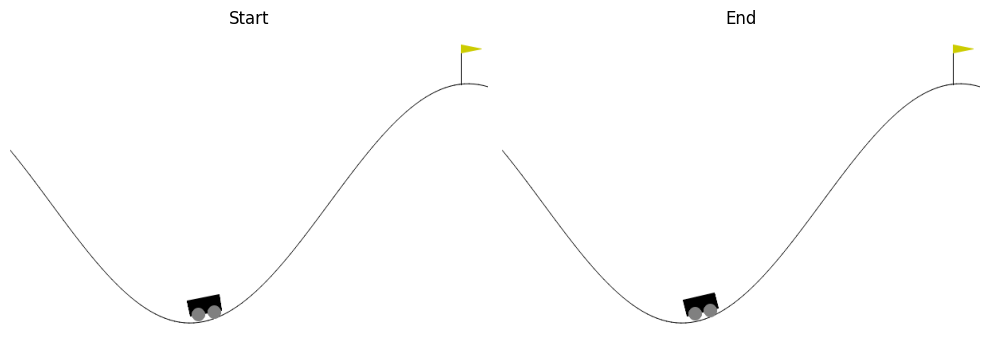

In [ ]:
# Initialize the agent
agent = RandomAgent()

# Store durations
episode_legth = []

# Number of episodes
num_episodes = 100

# Get initial render
agent.reset()
env_start = agent.env.render()

for episode in range(num_episodes):
    agent.reset()
    steps = 0

    # Random observation
    while not agent.done:
        action = agent.select_action()
        next_state, _ = agent.observe(action)
        agent.state = next_state
        steps += 1

    episode_legth.append(steps)

# Get final render and episode duration
env_end = agent.env.render()

# Visualize
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(env_start)
axs[0].axis('off')
axs[0].set_title(f'Start')

axs[1].imshow(env_end)
axs[1].axis('off')
axs[1].set_title(f'End')

plt.tight_layout()
plt.show()

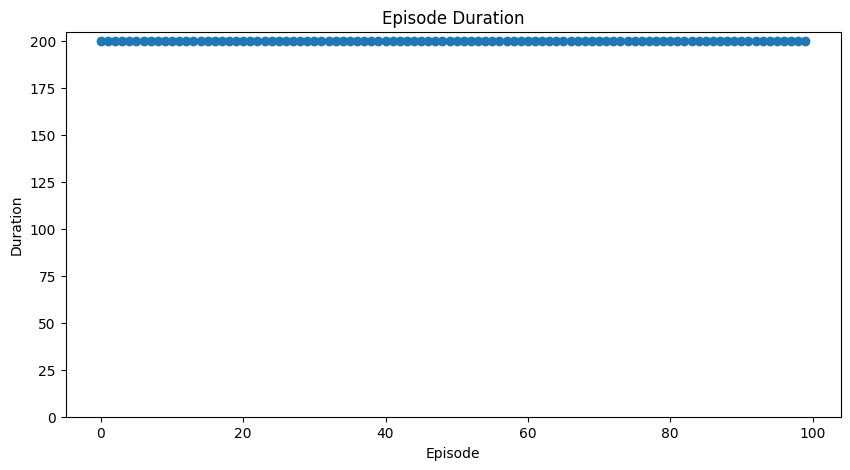

In [ ]:
# Plot the duration of each episode
plt.figure(figsize=(10, 5))
plt.scatter(range(len(episode_legth)), episode_legth)
plt.title('Episode Duration')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.ylim(0, 205)
plt.show()

# 3 - DQN


In [ ]:
from agents import DQNAgent

## 3.2 - No auxiliary reward


In [ ]:
# Start from scratch
agent = DQNAgent(n_episodes=1000)
episode_legth = []
episode_loss = []
episode_reward = []
episode_termination = []

for episode in tqdm(range(agent.n_episodes)):
    state = agent.reset()
    losses = []
    rewards = []

    for step in itertools.count():
        # Select Action
        action = agent.select_action(state=state)

        # Observe
        next_state, reward, _ = agent.observe(action=action)
        rewards.append(reward)

        # Store into replay buffer
        agent.replay_buffer.push(state, action, next_state, reward, int(agent.terminated))

        # Update the state
        state = copy(next_state)

        # Update the agent
        loss = agent.update()
        if loss is not None:
            losses.append(loss)

        # Update the Target Network
        if step % agent.target_update_frequency == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        if agent.done:
            episode_legth.append(step)
            episode_loss.append(losses)
            episode_reward.append(rewards)
            episode_termination.append(int(agent.terminated))

            if (episode) % 100 == 0:
                print()
                print(np.mean(episode_loss[-1]))
            break

    # decay the epsilon
    agent.epsilon *= agent.epsilon_decay

# Save the model and statistics
torch.save(agent.policy_net.state_dict(), 'new/3_2_dqn_policy_net.pt')
with open('new/3_2_dqn_stats.pkl', 'wb') as f:
    pickle.dump({
        "episode_legth": episode_legth,
        "episode_loss": episode_loss,
        "episode_reward": episode_reward,
        "episode_termination": episode_termination
    }, f)

  0%|          | 1/1000 [00:00<05:10,  3.22it/s]


0.651272725350786


 10%|█         | 101/1000 [01:11<11:13,  1.33it/s]


0.03495078406296671


 20%|██        | 201/1000 [02:22<09:51,  1.35it/s]


8.217851609515492e-05


 30%|███       | 301/1000 [03:34<08:22,  1.39it/s]


4.670268626341567e-05


 40%|████      | 401/1000 [04:47<07:16,  1.37it/s]


4.623966037343052e-05


 50%|█████     | 501/1000 [06:13<07:40,  1.08it/s]


1.2284918329896754e-06


 60%|██████    | 601/1000 [07:28<04:54,  1.35it/s]


3.4324602529522963e-06


 70%|███████   | 701/1000 [08:43<03:24,  1.46it/s]


6.5151400849572385e-06


 80%|████████  | 801/1000 [09:57<02:11,  1.52it/s]


2.3165434172369714e-05


 90%|█████████ | 901/1000 [11:13<01:15,  1.32it/s]


9.343086765511543e-05


100%|██████████| 1000/1000 [12:26<00:00,  1.34it/s]


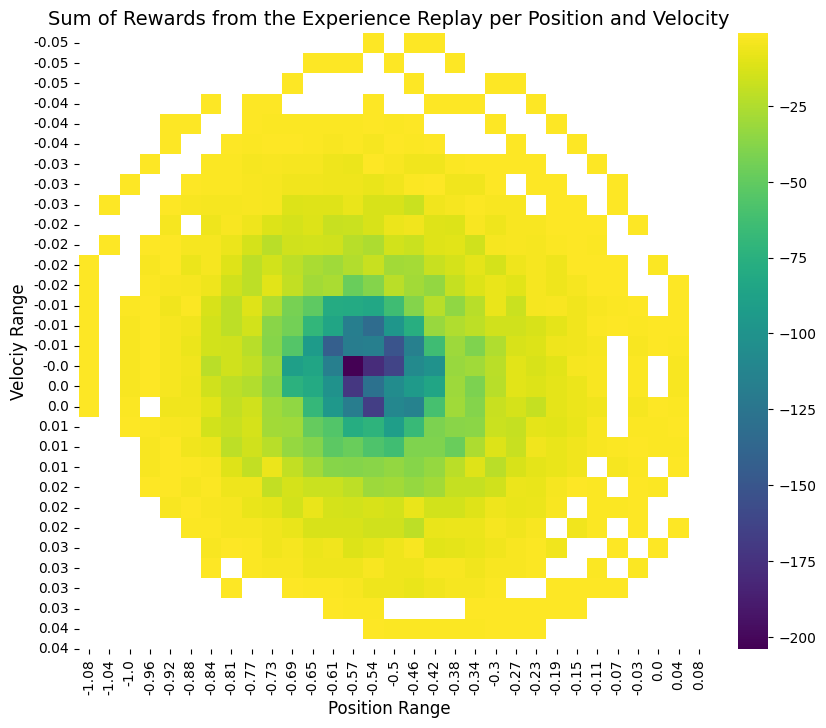

In [ ]:
# Extract positions and velocities and reward stored in the buffer
positions = [sample.state[0].item() for sample in agent.replay_buffer.buffer]
velocities = [sample.state[1].item() for sample in agent.replay_buffer.buffer]
rewards = [sample.reward.item() for sample in agent.replay_buffer.buffer]

# Create a 2D histogram with positions and velocities as axes, and rewards as the color
heatmap_data, xedges, yedges = np.histogram2d(positions, velocities, bins=30, weights=rewards)

# Replace 0s with NaNs
heatmap_data[heatmap_data == 0] = np.nan

# Plot heatmap
plt.figure(figsize=(10, 8))
cmap = sns.color_palette("viridis", as_cmap=True)
cmap.set_bad(color='white')
sns.heatmap(heatmap_data.T, xticklabels=xedges.round(2), yticklabels=yedges.round(2), cmap=cmap)
plt.xlabel('Position Range', fontsize=12)
plt.ylabel('Velociy Range', fontsize=12)
plt.title('Sum of Rewards from the Experience Replay per Position and Velocity', fontsize=14)
plt.show()

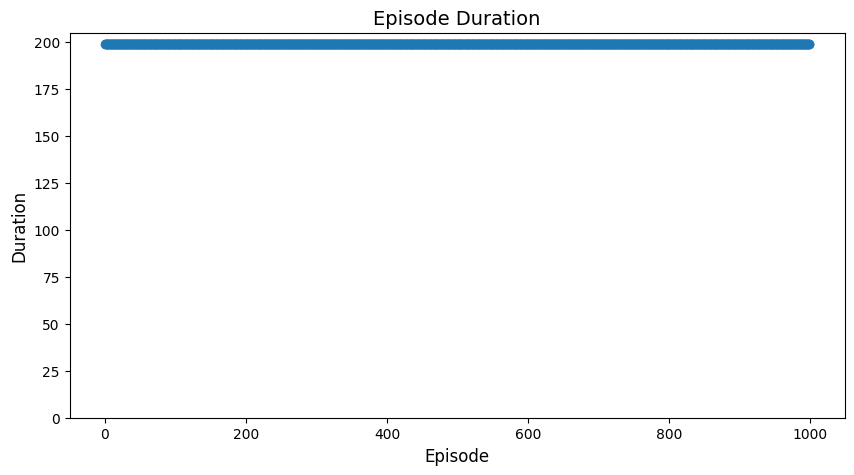

In [ ]:
# Plot duration of each episode
plt.figure(figsize=(10, 5))
plt.scatter(range(len(episode_legth)), episode_legth, marker='o')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Duration', fontsize=12)
plt.title('Episode Duration', fontsize=14)
plt.ylim(0, 205)
plt.show()

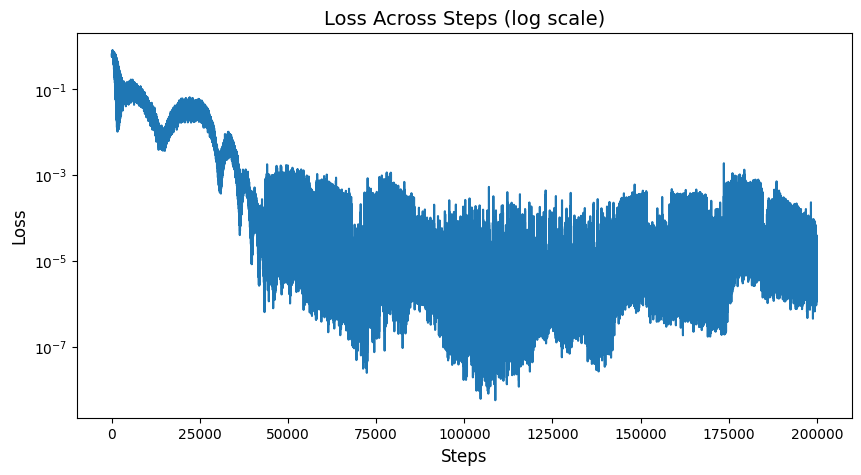

In [ ]:
# Concatenate all losses into a single list
all_losses = [loss for e_loss in episode_loss for loss in e_loss]

# Plot the losses across steps
plt.figure(figsize=(10, 5))
plt.plot(all_losses)

plt.xlabel('Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Across Steps (log scale)', fontsize=14)
plt.yscale('log')
plt.show()

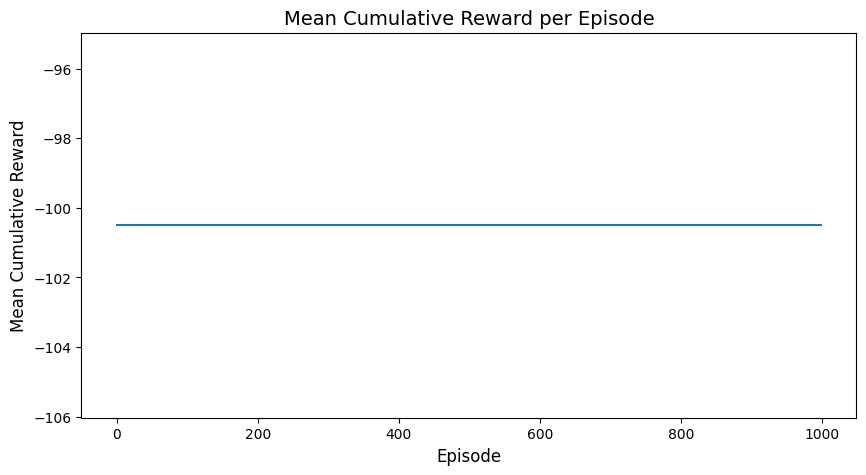

In [ ]:
# Plot the mean cumulative reward per episode
plt.figure(figsize=(10, 5))
plt.plot([np.mean(np.cumsum(reward)) for reward in episode_reward])

plt.xlabel('Episode', fontsize=12)
plt.ylabel('Mean Cumulative Reward', fontsize=12)
plt.title('Mean Cumulative Reward per Episode', fontsize=14)
plt.show()

## 3.3 - Heuristic reward function


In [ ]:
# Initialization
agent = DQNAgent(n_episodes=3000, aux_reward=True)
episode_length = []
episode_loss = []
episode_env_reward = []
episode_aux_reward = []
episode_termination = []

for episode in tqdm(range(agent.n_episodes)):
    state = agent.reset()
    losses = []
    env_rewards = []
    aux_rewards = []

    for step in itertools.count():
        # Select Action
        action = agent.select_action(state=state)

        # Observe
        next_state, env_reward, aux_reward = agent.observe(action=action)
        env_rewards.append(env_reward)
        aux_rewards.append(aux_reward)

        # Store into replay buffer
        agent.replay_buffer.push(state, action, next_state, env_reward + aux_reward, int(agent.terminated))

        # Update the state
        state = copy(next_state)

        # Update the agent
        loss = agent.update()
        if loss is not None:
            losses.append(loss)

        # Update the Target Network
        if step % agent.target_update_frequency == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        if agent.done:
            episode_length.append(step)
            episode_loss.append(losses)
            episode_env_reward.append(env_rewards)
            episode_aux_reward.append(aux_rewards)
            episode_termination.append(int(agent.terminated))

            if (episode) % 100 == 0:
                print()
                print(f"Loss: {round(np.mean(episode_loss[-1]), 5)} | Cum success: {sum(episode_termination)}")
            break

    # decay the epsilon
    agent.epsilon *= agent.epsilon_decay

# Save the model and statistics
torch.save(agent.policy_net.state_dict(), 'new/3_3_dqn_policy_net_abs_2pos_vel.pt')
with open('new/3_3_dqn_stats_abs_2pos_vel.pkl', 'wb') as f:
    pickle.dump({
        "episode_length": episode_length,
        "episode_loss": episode_loss,
        "episode_env_reward": episode_env_reward,
        "episode_aux_reward": episode_aux_reward,
        "episode_termination": episode_termination
    }, f)

  0%|          | 1/3000 [00:00<35:25,  1.41it/s]


Loss: 0.57642 | Cum success: 0


  3%|▎         | 101/3000 [01:17<31:35,  1.53it/s]


Loss: 0.02862 | Cum success: 0


  7%|▋         | 201/3000 [02:29<30:49,  1.51it/s]


Loss: 0.01356 | Cum success: 0


 10%|█         | 301/3000 [03:42<31:42,  1.42it/s]


Loss: 0.02183 | Cum success: 0


 13%|█▎        | 401/3000 [04:56<29:07,  1.49it/s]


Loss: 0.02796 | Cum success: 0


 17%|█▋        | 501/3000 [06:16<38:17,  1.09it/s]


Loss: 0.38907 | Cum success: 0


 20%|██        | 601/3000 [07:30<27:25,  1.46it/s]


Loss: 1.69405 | Cum success: 24


 23%|██▎       | 701/3000 [08:44<26:47,  1.43it/s]


Loss: 2.01734 | Cum success: 65


 27%|██▋       | 801/3000 [09:55<26:47,  1.37it/s]


Loss: 1.05094 | Cum success: 108


 30%|███       | 901/3000 [11:06<24:32,  1.43it/s]


Loss: 0.76306 | Cum success: 144


 33%|███▎      | 1001/3000 [12:46<23:37,  1.41it/s]


Loss: 0.35294 | Cum success: 216


 37%|███▋      | 1101/3000 [14:04<21:33,  1.47it/s]


Loss: 0.15675 | Cum success: 301


 40%|████      | 1201/3000 [15:07<18:42,  1.60it/s]


Loss: 0.1036 | Cum success: 389


 43%|████▎     | 1301/3000 [16:16<17:31,  1.62it/s]


Loss: 0.10888 | Cum success: 475


 47%|████▋     | 1401/3000 [17:18<14:14,  1.87it/s]


Loss: 0.12595 | Cum success: 566


 50%|█████     | 1501/3000 [18:18<13:01,  1.92it/s]


Loss: 0.1027 | Cum success: 660


 53%|█████▎    | 1601/3000 [19:18<15:44,  1.48it/s]


Loss: 0.12649 | Cum success: 755


 57%|█████▋    | 1701/3000 [20:17<14:35,  1.48it/s]


Loss: 0.11011 | Cum success: 852


 60%|██████    | 1801/3000 [21:16<15:21,  1.30it/s]


Loss: 0.12556 | Cum success: 950


 63%|██████▎   | 1901/3000 [22:15<12:03,  1.52it/s]


Loss: 0.08243 | Cum success: 1048


 67%|██████▋   | 2001/3000 [23:14<09:52,  1.69it/s]


Loss: 0.08059 | Cum success: 1148


 70%|███████   | 2101/3000 [24:13<08:30,  1.76it/s]


Loss: 0.06567 | Cum success: 1248


 73%|███████▎  | 2201/3000 [25:13<07:01,  1.90it/s]


Loss: 0.07323 | Cum success: 1347


 77%|███████▋  | 2301/3000 [26:11<05:55,  1.97it/s]


Loss: 0.08684 | Cum success: 1447


 80%|████████  | 2401/3000 [27:09<05:11,  1.93it/s]


Loss: 0.08764 | Cum success: 1546


 83%|████████▎ | 2501/3000 [28:07<04:21,  1.91it/s]


Loss: 0.06657 | Cum success: 1645


 87%|████████▋ | 2601/3000 [29:04<03:28,  1.91it/s]


Loss: 0.0646 | Cum success: 1745


 90%|█████████ | 2701/3000 [30:03<02:34,  1.94it/s]


Loss: 0.06633 | Cum success: 1845


 93%|█████████▎| 2801/3000 [31:04<02:10,  1.53it/s]


Loss: 0.07007 | Cum success: 1945


 97%|█████████▋| 2901/3000 [32:05<00:56,  1.74it/s]


Loss: 0.07189 | Cum success: 2044


100%|██████████| 3000/3000 [33:04<00:00,  1.51it/s]


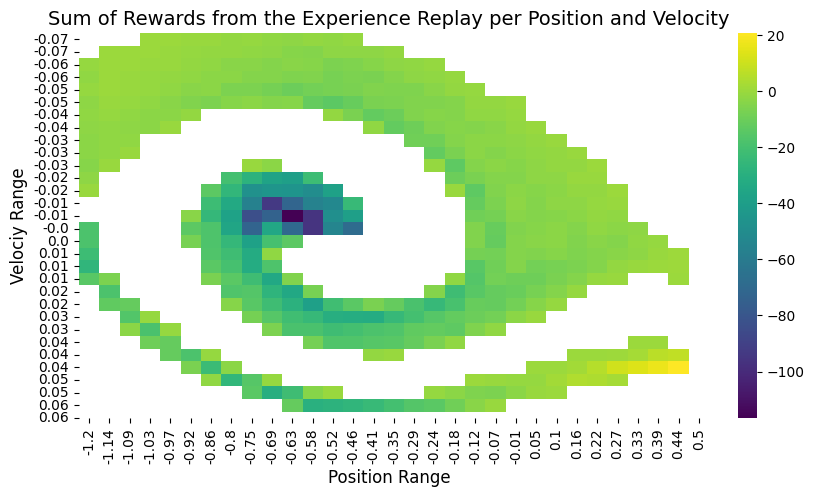

In [ ]:
# Extract positions and velocities and reward stored in the buffer
positions = [sample.state[0].item() for sample in agent.replay_buffer.buffer]
velocities = [sample.state[1].item() for sample in agent.replay_buffer.buffer]
rewards = [sample.reward.item() for sample in agent.replay_buffer.buffer]

# Create a 2D histogram with positions and velocities as axes, and rewards as the color
heatmap_data, xedges, yedges = np.histogram2d(positions, velocities, bins=30, weights=rewards)

# Replace 0s with NaNs
heatmap_data[heatmap_data == 0] = np.nan

# Plot heatmap
plt.figure(figsize=(10, 8))
cmap = sns.color_palette("viridis", as_cmap=True)
cmap.set_bad(color='white')
sns.heatmap(heatmap_data.T, xticklabels=xedges.round(2), yticklabels=yedges.round(2), cmap=cmap)
plt.xlabel('Position Range', fontsize=12)
plt.ylabel('Velociy Range', fontsize=12)
plt.title('Sum of Rewards from the Experience Replay per Position and Velocity', fontsize=14)
plt.show()

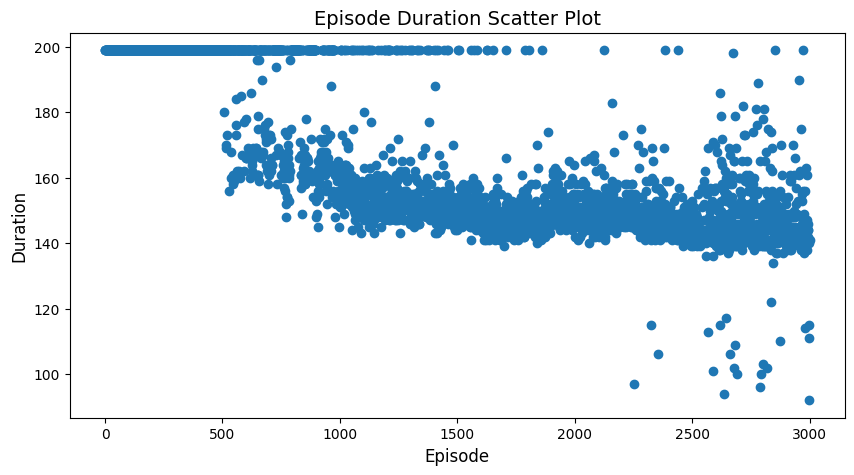

In [ ]:
# Plot duration of each episode
plt.figure(figsize=(10, 5))
plt.scatter(range(len(episode_length)), episode_length, marker='o')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Duration', fontsize=12)
plt.title('Episode Duration Scatter Plot', fontsize=14)
plt.show()

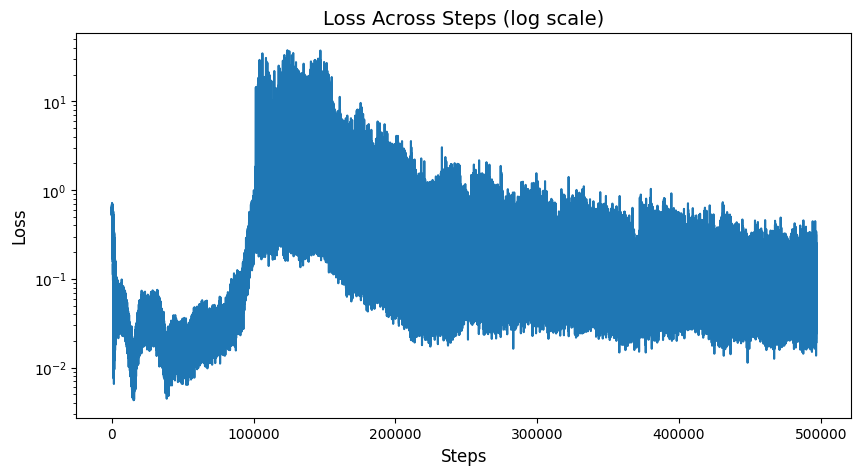

In [ ]:
# Concatenate all losses into a single list
all_losses = [loss for e_loss in episode_loss for loss in e_loss]

# Plot the losses across steps
plt.figure(figsize=(10, 5))
plt.plot(all_losses)

plt.xlabel('Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Across Steps (log scale)', fontsize=14)
plt.yscale('log')
plt.show()

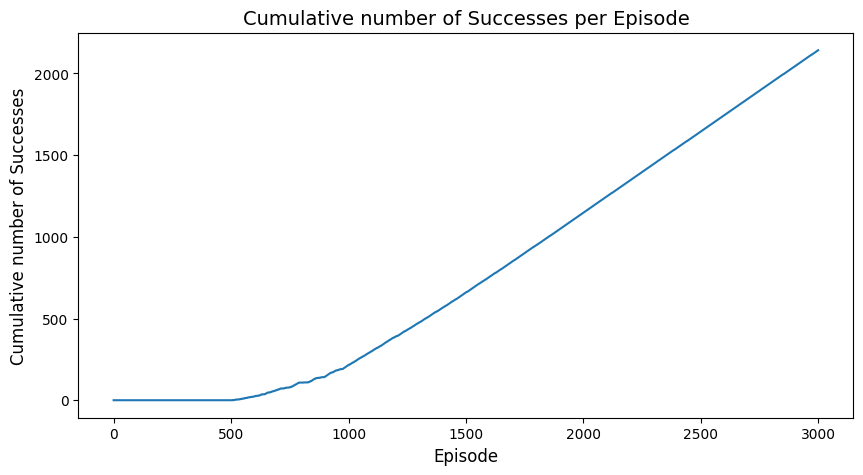

In [ ]:
# Get the cumulative number of successes
cum_termination = np.cumsum(episode_termination)

# Plot the cumulative number of successes
plt.figure(figsize=(10, 5))
plt.plot(cum_termination)

plt.xlabel('Episode', fontsize=12)
plt.ylabel('Cumulative number of Successes', fontsize=12)
plt.title('Cumulative number of Successes per Episode', fontsize=14)
plt.show()

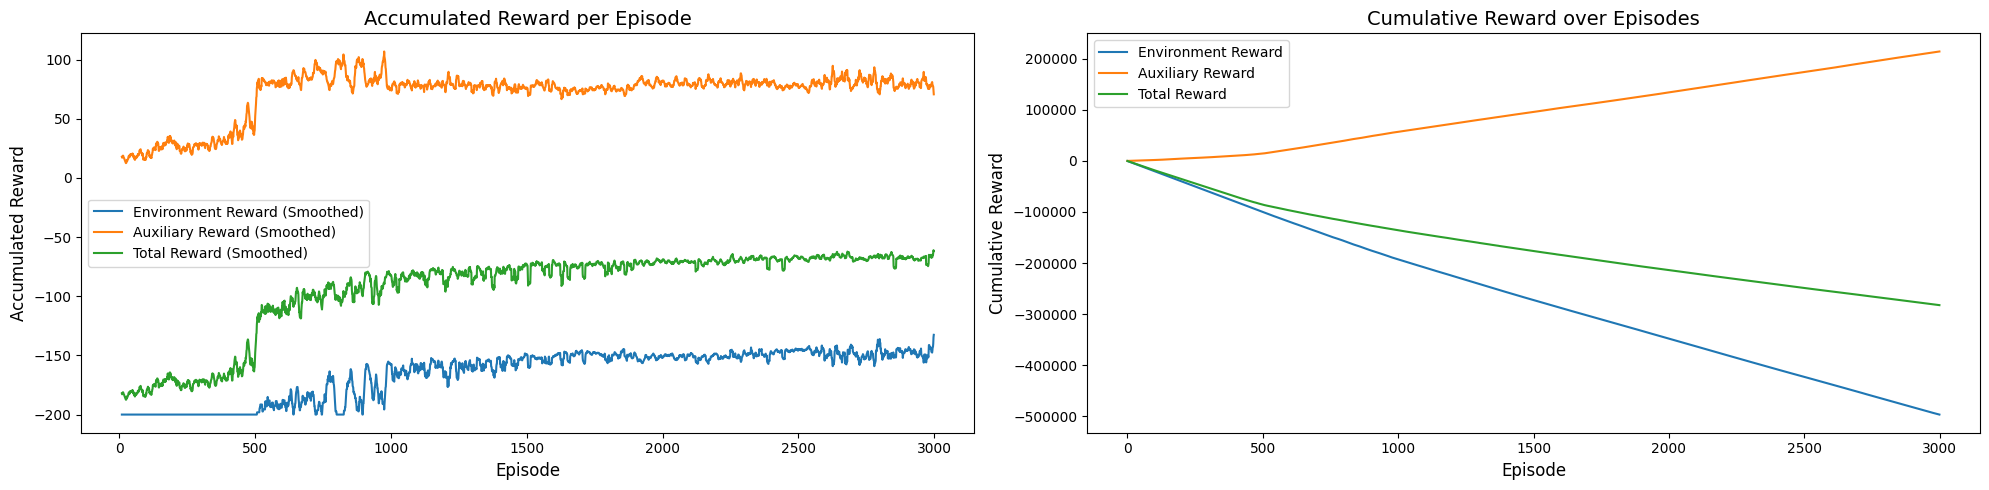

In [ ]:
# Calculate accumulated reward per episode
accumulated_rewards_env = [sum(episode) for episode in episode_env_reward]
accumulated_rewards_aux = [sum(episode) for episode in episode_aux_reward]
accumulated_rewards_total = [env + aux for env, aux in zip(accumulated_rewards_env, accumulated_rewards_aux)]

# Smooth accumulated rewards using a rolling window
window_size = 10
accumulated_rewards_env_smooth = pd.Series(accumulated_rewards_env).rolling(window=window_size).mean()
accumulated_rewards_aux_smooth = pd.Series(accumulated_rewards_aux).rolling(window=window_size).mean()
accumulated_rewards_total_smooth = pd.Series(accumulated_rewards_total).rolling(window=window_size).mean()

# Calculate cumulative reward over episodes
cumulative_rewards_env = np.cumsum(accumulated_rewards_env)
cumulative_rewards_aux = np.cumsum(accumulated_rewards_aux)
cumulative_rewards_total = np.cumsum(accumulated_rewards_total)

# Plot accumulated reward per episode
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(accumulated_rewards_env_smooth, label='Environment Reward (Smoothed)')
plt.plot(accumulated_rewards_aux_smooth, label='Auxiliary Reward (Smoothed)')
plt.plot(accumulated_rewards_total_smooth, label='Total Reward (Smoothed)')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Accumulated Reward', fontsize=12)
plt.title('Accumulated Reward per Episode', fontsize=14)
plt.legend()

# Plot cumulative reward over episodes
plt.subplot(1, 2, 2)
plt.plot(cumulative_rewards_env, label='Environment Reward')
plt.plot(cumulative_rewards_aux, label='Auxiliary Reward')
plt.plot(cumulative_rewards_total, label='Total Reward')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Cumulative Reward', fontsize=12)
plt.title('Cumulative Reward over Episodes', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()


## 3.4 - Non domain-specific reward


In [ ]:
agent = DQNAgent(n_episodes=3000, rnd_reward=True)
episode_length = []
episode_dqn_loss = []
episode_env_reward = []
episode_rnd_reward = []
episode_termination = []

for episode in tqdm(range(agent.n_episodes)):
    state = agent.reset()
    dqn_losses = []
    rnd_losses = []
    env_rewards = []
    rnd_rewards = []

    for step in itertools.count():
        # Store the state
        agent.rnd_states.append(state.numpy())

        # Select Action
        action = agent.select_action(state=state)

        # Observe
        next_state, env_reward, rnd_reward = agent.observe(action=action)
        env_rewards.append(env_reward)
        rnd_rewards.append(rnd_reward)

        # Store into replay buffer
        agent.replay_buffer.push(state, action, next_state, env_reward + rnd_reward, int(agent.terminated))

        # Update the state
        state = copy(next_state)

        # Update the agent
        dqn_loss = agent.update()
        if dqn_loss is not None:
            dqn_losses.append(dqn_loss)


        # Update the Target Network
        if step % agent.target_update_frequency == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        if agent.done:
            episode_length.append(step)
            episode_dqn_loss.append(dqn_losses)
            episode_env_reward.append(env_rewards)
            episode_rnd_reward.append(rnd_rewards)
            episode_termination.append(int(agent.terminated))

            if (episode) % 100 == 0:
                print()
                print(f"Loss: {round(np.mean(episode_dqn_loss[-1]), 5)} | Cum success: {sum(episode_termination)}")
            break

    # decay the epsilon
    agent.epsilon *= agent.epsilon_decay

# Save the model and statistics
torch.save(agent.policy_net.state_dict(), 'new/3_4_dqn_policy_net.pt')
with open('new/3_4_dqn_stats.pkl', 'wb') as f:
    pickle.dump({
        "episode_length": episode_length,
        "episode_dqn_loss": episode_dqn_loss,
        "episode_env_reward": episode_env_reward,
        "episode_rnd_reward": episode_rnd_reward,
        "episode_termination": episode_termination
    }, f)

  0%|          | 1/3000 [00:01<1:09:48,  1.40s/it]


Loss: 0.80287 | Cum success: 0


  3%|▎         | 101/3000 [01:34<41:15,  1.17it/s]


Loss: 0.21612 | Cum success: 0


  7%|▋         | 201/3000 [03:09<44:56,  1.04it/s]


Loss: 0.10355 | Cum success: 0


 10%|█         | 301/3000 [04:42<40:18,  1.12it/s]


Loss: 0.05423 | Cum success: 0


 13%|█▎        | 401/3000 [06:17<37:41,  1.15it/s]


Loss: 0.08485 | Cum success: 0


 17%|█▋        | 501/3000 [07:52<38:01,  1.10it/s]


Loss: 0.55513 | Cum success: 6


 20%|██        | 601/3000 [09:31<41:27,  1.04s/it]


Loss: 0.63287 | Cum success: 33


 23%|██▎       | 701/3000 [11:01<30:47,  1.24it/s]


Loss: 0.52034 | Cum success: 74


 27%|██▋       | 801/3000 [12:26<26:00,  1.41it/s]


Loss: 0.52281 | Cum success: 141


 30%|███       | 901/3000 [13:48<25:07,  1.39it/s]


Loss: 0.49849 | Cum success: 226


 33%|███▎      | 1001/3000 [15:08<31:24,  1.06it/s]


Loss: 0.48721 | Cum success: 313


 37%|███▋      | 1101/3000 [16:25<23:46,  1.33it/s]


Loss: 0.31665 | Cum success: 406


 40%|████      | 1201/3000 [17:43<27:39,  1.08it/s]


Loss: 0.25379 | Cum success: 504


 43%|████▎     | 1301/3000 [18:59<19:30,  1.45it/s]


Loss: 0.20585 | Cum success: 604


 47%|████▋     | 1401/3000 [20:13<18:24,  1.45it/s]


Loss: 0.19714 | Cum success: 703


 50%|█████     | 1501/3000 [21:29<19:54,  1.26it/s]


Loss: 0.18701 | Cum success: 803


 53%|█████▎    | 1601/3000 [22:41<16:21,  1.43it/s]


Loss: 0.1701 | Cum success: 903


 57%|█████▋    | 1701/3000 [23:54<14:50,  1.46it/s]


Loss: 0.21602 | Cum success: 1003


 60%|██████    | 1801/3000 [25:09<14:20,  1.39it/s]


Loss: 0.3943 | Cum success: 1102


 63%|██████▎   | 1901/3000 [26:25<15:00,  1.22it/s]


Loss: 0.18894 | Cum success: 1202


 67%|██████▋   | 2001/3000 [27:39<11:09,  1.49it/s]


Loss: 0.20354 | Cum success: 1301


 70%|███████   | 2101/3000 [28:50<09:56,  1.51it/s]


Loss: 0.27016 | Cum success: 1400


 73%|███████▎  | 2201/3000 [30:01<08:42,  1.53it/s]


Loss: 0.14569 | Cum success: 1500


 77%|███████▋  | 2301/3000 [31:13<07:45,  1.50it/s]


Loss: 0.20552 | Cum success: 1600


 80%|████████  | 2401/3000 [32:24<06:24,  1.56it/s]


Loss: 0.23184 | Cum success: 1700


 83%|████████▎ | 2501/3000 [33:35<05:37,  1.48it/s]


Loss: 0.33752 | Cum success: 1800


 87%|████████▋ | 2601/3000 [34:47<05:00,  1.33it/s]


Loss: 0.20913 | Cum success: 1900


 90%|█████████ | 2701/3000 [36:08<03:38,  1.37it/s]


Loss: 0.26207 | Cum success: 2000


 93%|█████████▎| 2801/3000 [37:16<01:57,  1.69it/s]


Loss: 0.54334 | Cum success: 2099


 97%|█████████▋| 2901/3000 [38:27<01:11,  1.39it/s]


Loss: 0.31691 | Cum success: 2198


100%|██████████| 3000/3000 [39:37<00:00,  1.26it/s]


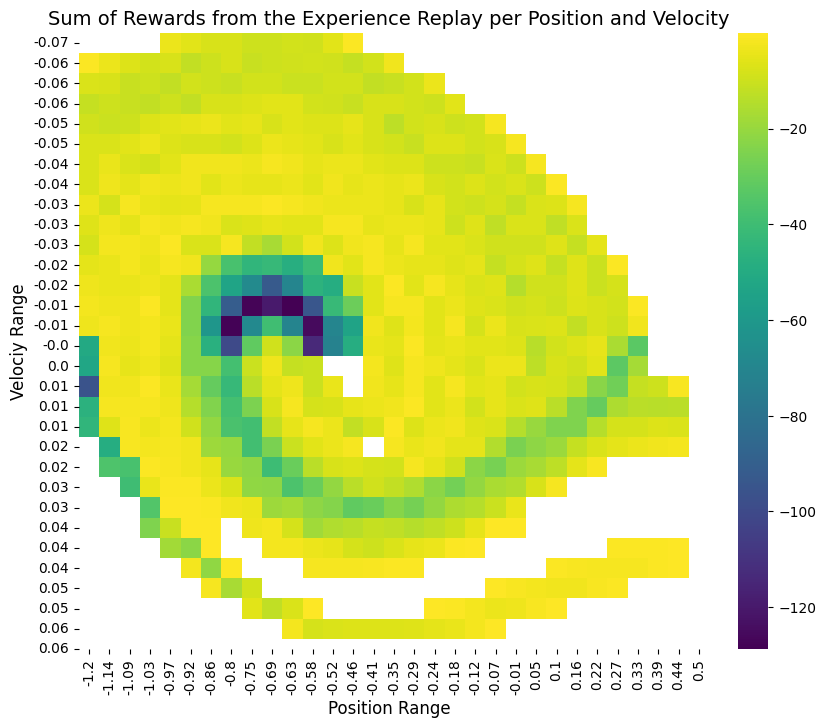

In [ ]:
# Extract positions and velocities and reward stored in the buffer
positions = [sample.state[0].item() for sample in agent.replay_buffer.buffer]
velocities = [sample.state[1].item() for sample in agent.replay_buffer.buffer]
rewards = [sample.reward.item() for sample in agent.replay_buffer.buffer]

# Create a 2D histogram with positions and velocities as axes, and rewards as the color
heatmap_data, xedges, yedges = np.histogram2d(positions, velocities, bins=30, weights=rewards)

# Replace 0s with NaNs
heatmap_data[heatmap_data == 0] = np.nan

# Plot heatmap
plt.figure(figsize=(10, 8))
cmap = sns.color_palette("viridis", as_cmap=True)
cmap.set_bad(color='white')
sns.heatmap(heatmap_data.T, xticklabels=xedges.round(2), yticklabels=yedges.round(2), cmap=cmap)
plt.xlabel('Position Range', fontsize=12)
plt.ylabel('Velociy Range', fontsize=12)
plt.title('Sum of Rewards from the Experience Replay per Position and Velocity', fontsize=14)
plt.show()

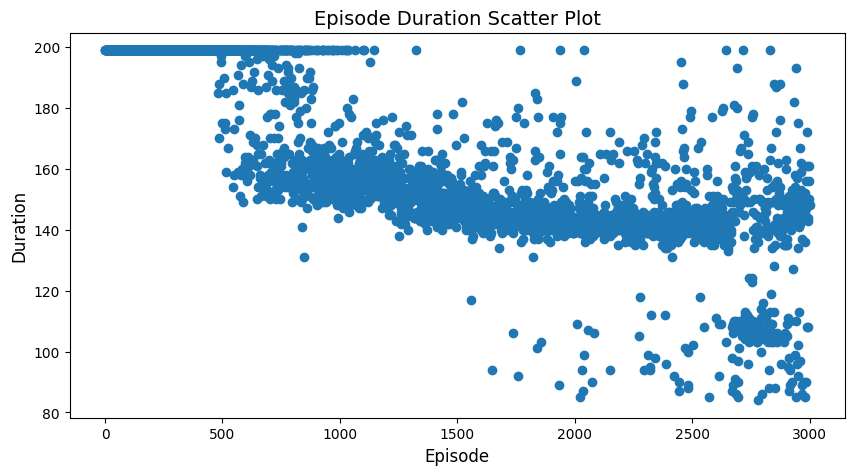

In [ ]:
# Plot duration of each episode
plt.figure(figsize=(10, 5))
plt.scatter(range(len(episode_length)), episode_length, marker='o')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Duration', fontsize=12)
plt.title('Episode Duration Scatter Plot', fontsize=14)
plt.show()

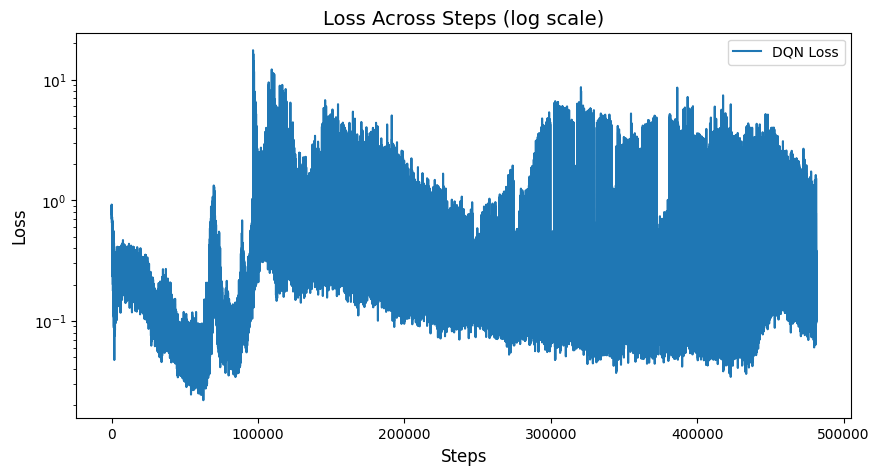

In [ ]:
# Concatenate all losses into a single list
all_dqn_losses = [loss for e_loss in episode_dqn_loss for loss in e_loss]

# Plot the losses across steps
plt.figure(figsize=(10, 5))
plt.plot(all_dqn_losses, label='DQN Loss')

plt.xlabel('Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Across Steps (log scale)', fontsize=14)
plt.yscale('log')
plt.legend()
plt.show()

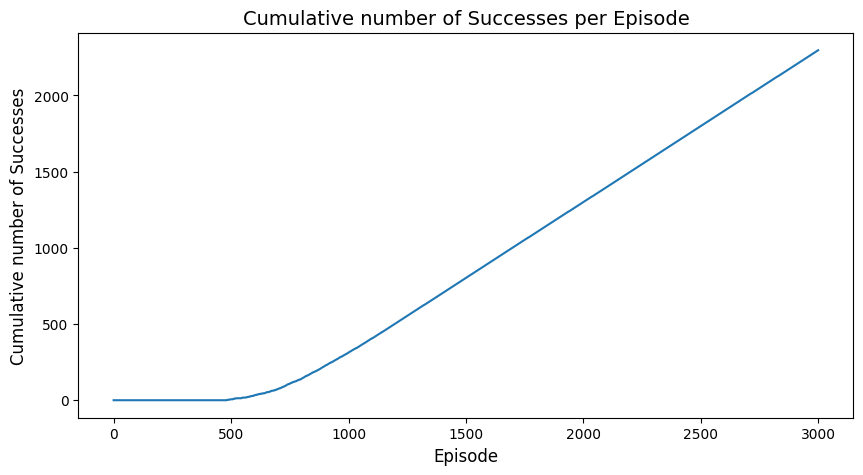

In [ ]:
# Get the cumulative number of successes
cum_termination = np.cumsum(episode_termination)

# Plot the cumulative number of successes
plt.figure(figsize=(10, 5))
plt.plot(cum_termination)

plt.xlabel('Episode', fontsize=12)
plt.ylabel('Cumulative number of Successes', fontsize=12)
plt.title('Cumulative number of Successes per Episode', fontsize=14)
plt.show()

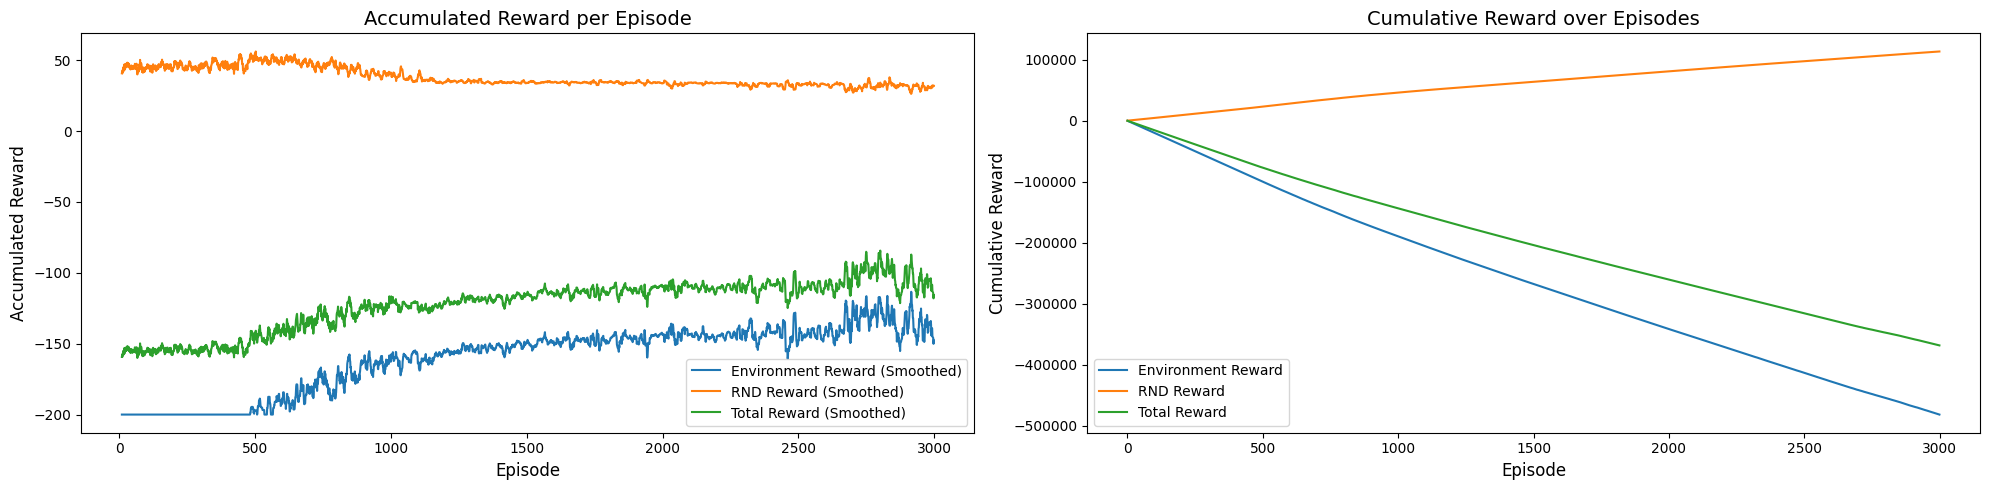

In [ ]:
# Calculate accumulated reward per episode
accumulated_rewards_env = [sum(episode) for episode in episode_env_reward]
accumulated_rewards_rnd = [sum(episode) for episode in episode_rnd_reward]
accumulated_rewards_total = [env + aux for env, aux in zip(accumulated_rewards_env, accumulated_rewards_rnd)]

# Smooth accumulated rewards using a rolling window
window_size = 10
accumulated_rewards_env_smooth = pd.Series(accumulated_rewards_env).rolling(window=window_size).mean()
accumulated_rewards_rnd_smooth = pd.Series(accumulated_rewards_rnd).rolling(window=window_size).mean()
accumulated_rewards_total_smooth = pd.Series(accumulated_rewards_total).rolling(window=window_size).mean()

# Calculate cumulative reward over episodes
cumulative_rewards_env = np.cumsum(accumulated_rewards_env)
cumulative_rewards_aux = np.cumsum(accumulated_rewards_rnd)
cumulative_rewards_total = np.cumsum(accumulated_rewards_total)

# Plot accumulated reward per episode
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(accumulated_rewards_env_smooth, label='Environment Reward (Smoothed)')
plt.plot(accumulated_rewards_rnd_smooth, label='RND Reward (Smoothed)')
plt.plot(accumulated_rewards_total_smooth, label='Total Reward (Smoothed)')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Accumulated Reward', fontsize=12)
plt.title('Accumulated Reward per Episode', fontsize=14)
plt.legend()

# Plot cumulative reward over episodes
plt.subplot(1, 2, 2)
plt.plot(cumulative_rewards_env, label='Environment Reward')
plt.plot(cumulative_rewards_aux, label='RND Reward')
plt.plot(cumulative_rewards_total, label='Total Reward')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Cumulative Reward', fontsize=12)
plt.title('Cumulative Reward over Episodes', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

# 4 - Dyna


## 4.3 - Implementation


In [3]:
from agents import DynaAgent

def save_model(agent, filename, rewards, durations, terminations, states, all_Q):
    with open(filename, 'wb') as f:
        pickle.dump({
            'Q': agent.Q,
            'P': agent.P,
            'R': agent.R,
            'visited_states':agent.visited_states,
            "q_updates":agent.q_updates,
            'epsilon': agent.epsilon,
            "rewards":rewards,
            "durations":durations,
            "terminations":terminations,
            "states":states,
            "all_Q":all_Q
        }, f)
        print(f"Model saved to {filename}")

def load_model(agent, filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        agent.Q = data['Q']
        agent.P = data['P']
        agent.R = data['R']
        agent.visited_states = data['visited_states']
        agent.epsilon = data['epsilon']
        agent.q_updates = data['q_updates']
        rewards = data['rewards']
        durations = data['durations']
        terminations = data['terminations']
        states = data['states']
        all_Q = data['all_Q']

        print(f"Model loaded from {filename}")
        return rewards, durations, terminations, states, all_Q

#### Normal bins


In [3]:
# Dyna Agent
agent = DynaAgent()
rewards = []
durations = []
terminations = []
states = []
all_Q = []
all_visited_states = []

for episode in tqdm(range(3000)):
    state, _ = agent.env.reset()
    done = False
    truncated = False
    total_reward = []
    next_states = []
    Qs = []
    visited_states = []
    steps = 0
    while not done and not truncated:
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = agent.env.step(action)
        agent.observe(state, action, next_state, reward)
        state = next_state
        total_reward.append(reward)
        next_states.append(next_state)
        Qs.append(copy(agent.Q))
        visited_states.append(agent.visited_states)
        steps += 1

    terminations.append(int(done))
    durations.append(steps)
    rewards.append(total_reward)
    states.append(next_states)
    all_Q.append(Qs)
    all_visited_states.append(visited_states)
    agent.decay_epsilon()

# Save the model
save_model(agent, "4_normal_bins_stats.pkl", rewards, durations, terminations, states, all_Q)

100%|██████████| 3000/3000 [18:47<00:00,  2.66it/s]


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].scatter(range(len(durations)), durations)
axs[0].set_title('Episode Duration', fontsize=14)
axs[0].set_xlabel('Episode', fontsize=12)
axs[0].set_ylabel('Duration', fontsize=12)

cum_reward = [np.mean(np.cumsum(reward)) for reward in rewards]
axs[1].scatter(range(len(cum_reward)), cum_reward)
axs[1].set_title('Mean Cumulative Reward per Episode', fontsize=14)
axs[1].set_xlabel('Episode', fontsize=12)
axs[1].set_ylabel('Mean Cumulative Reward', fontsize=12)
plt.tight_layout()
plt.show()

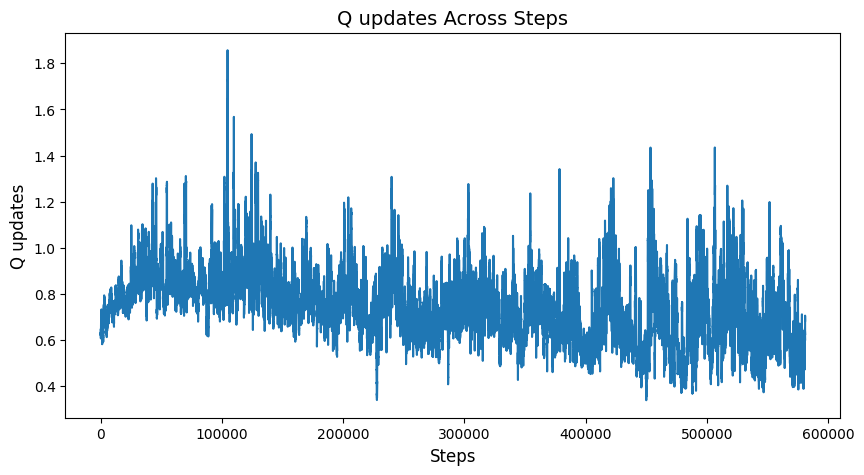

In [7]:
# Get Q updates moving average
window_size = 500
q_update_moving_avg = pd.Series(agent.q_updates).rolling(window=window_size).mean().dropna().to_list()

# Plot the q_updates across steps
plt.figure(figsize=(10, 5))
plt.plot(q_update_moving_avg)

plt.xlabel('Steps', fontsize=12)
plt.ylabel('Q updates', fontsize=12)
plt.title('Q updates Across Steps', fontsize=14)
plt.show()

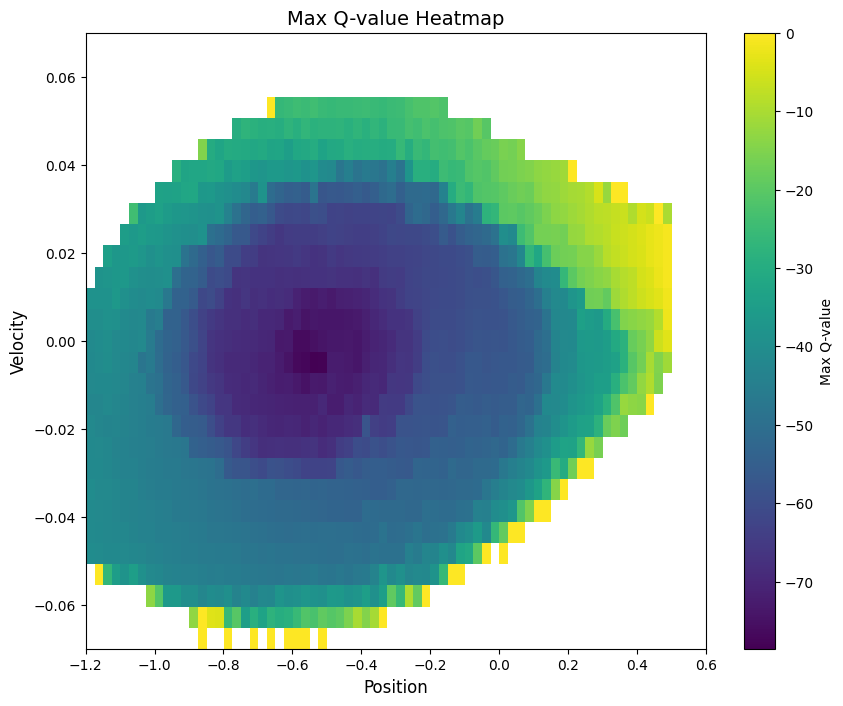

In [8]:
# Mask the Q values
max_q_values = np.max(agent.Q, axis=2)
visited_states = agent.visited_states
masked_q_values = np.full((agent.n_states[0], agent.n_states[1]), np.nan)

for state, _ in visited_states:
    masked_q_values[state[0], state[1]] = max_q_values[state[0], state[1]]

# Plot the max Q-values
plt.figure(figsize=(10, 8))
plt.imshow(masked_q_values.transpose(), extent=[-1.2, 0.6, -0.07, 0.07], origin='lower', cmap='viridis', aspect='auto') # [left, right, bottom, top]
plt.colorbar(label='Max Q-value')
plt.title('Max Q-value Heatmap', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Velocity', fontsize=12)
plt.show()

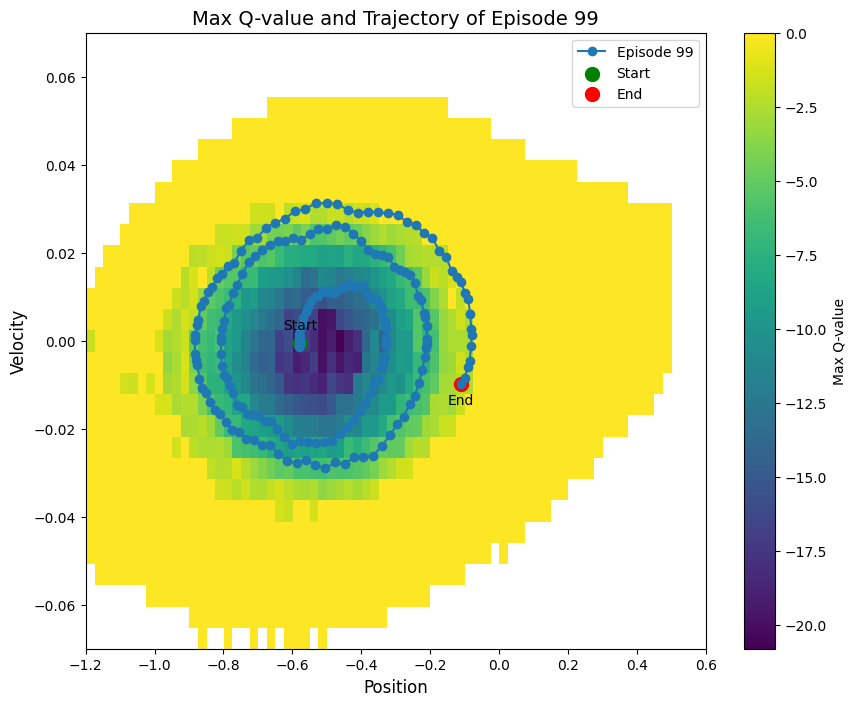

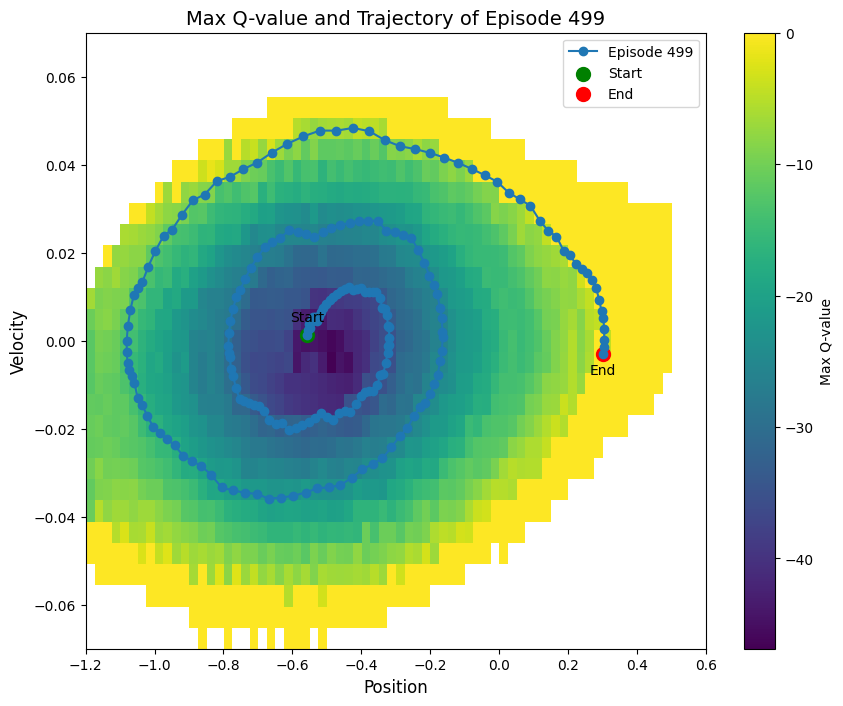

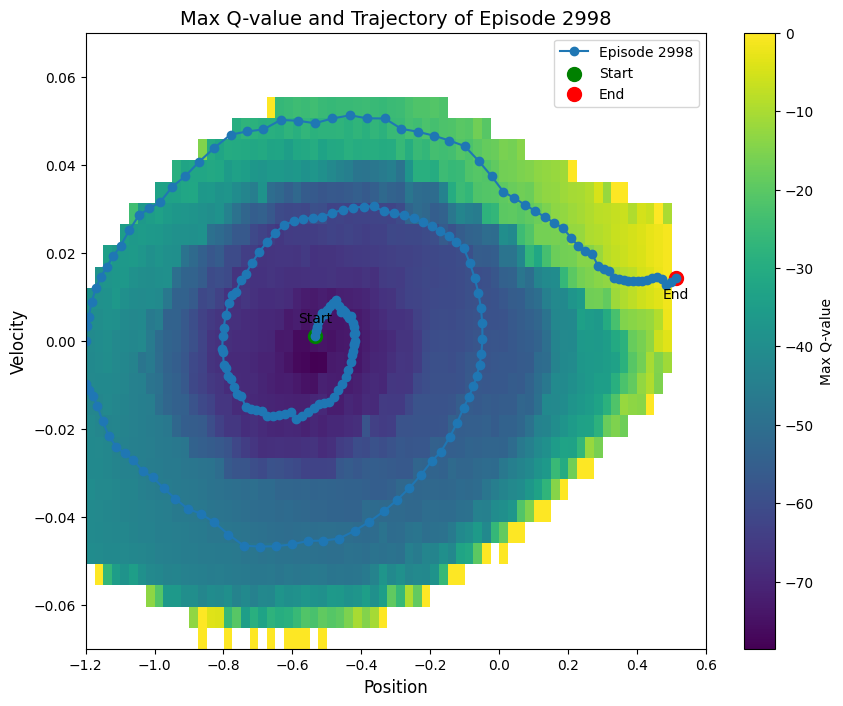

In [12]:
for episode in [99, 499, 2998]:
  # Mask the Q values
  max_q_values = np.max(np.array(all_Q[episode])[-1], axis=-1)
  visited_states = agent.visited_states
  masked_q_values = np.full((agent.n_states[0], agent.n_states[1]), np.nan)

  for state, _ in visited_states:
      masked_q_values[state[0], state[1]] = max_q_values[state[0], state[1]]

  # Plot the max Q-values
  plt.figure(figsize=(10, 8))
  plt.imshow(masked_q_values.transpose(), extent=[-1.2, 0.6, -0.07, 0.07], origin='lower', cmap='viridis', aspect='auto') # [left, right, bottom, top]
  plt.colorbar(label='Max Q-value')

  # Extract positions and velocities from the 100th episode
  positions = [s[0] for s in states[episode]]
  velocities = [s[1] for s in states[episode]]

  # Plot the positions and velocities
  plt.plot(positions, velocities, marker='o', label=f'Episode {episode}')

  # Mark the start point
  plt.scatter(positions[0], velocities[0], color='green', s=100, label='Start')

  # Mark the end point
  plt.scatter(positions[-1], velocities[-1], color='red', s=100, label='End')

  # Optional: Add annotations for start and end points
  plt.annotate('Start', (positions[0], velocities[0]), textcoords="offset points", xytext=(0,10), ha='center')
  plt.annotate('End', (positions[-1], velocities[-1]), textcoords="offset points", xytext=(0,-15), ha='center')

  # Add labels and legend
  plt.xlabel('Position', fontsize=12)
  plt.ylabel('Velocity', fontsize=12)
  plt.title(f'Max Q-value and Trajectory of Episode {episode}', fontsize=14)
  plt.legend()
  plt.show()

#### Large bins


In [102]:
agent = DynaAgent(discr_step=(0.1, 0.02))
rewards = []
durations = []
terminations = []
states = []
all_Q = []

for episode in tqdm(range(3000)):
    state, _ = agent.env.reset()
    done = False
    truncated = False
    total_reward = []
    next_states = []
    Qs = []
    steps = 0
    while not done and not truncated:
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = agent.env.step(action)
        agent.observe(state, action, next_state, reward)
        state = next_state
        total_reward.append(reward)
        next_states.append(next_state)
        Qs.append(agent.Q)
        steps += 1

    terminations.append(int(done))
    durations.append(steps)
    rewards.append(total_reward)
    states.append(next_states)
    all_Q.append(Qs)
    agent.decay_epsilon()

# Save the model
save_model(agent, "new/4_large_bins_stats.pkl", rewards, durations, terminations, states, all_Q)

100%|██████████| 3000/3000 [06:22<00:00,  7.84it/s]


Model saved to new/4_large_bins_stats.pkl


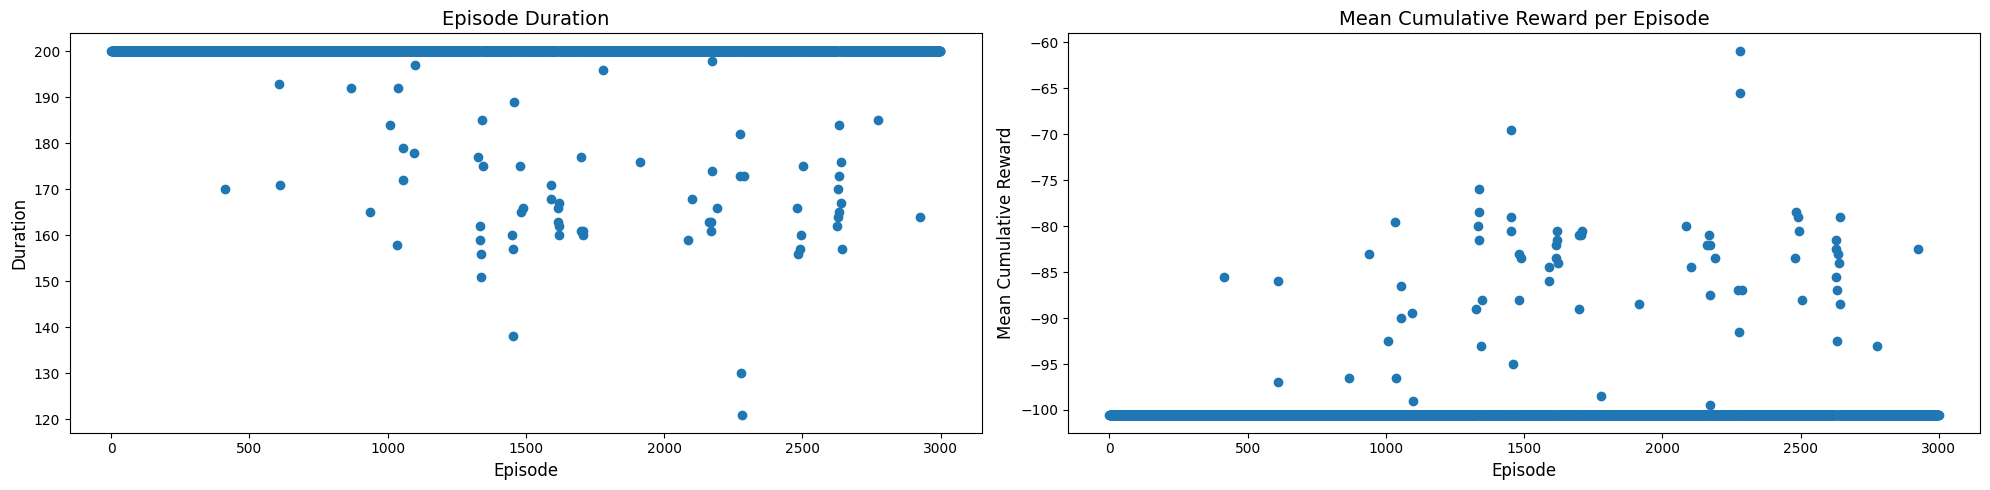

In [103]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].scatter(range(len(durations)), durations)
axs[0].set_title('Episode Duration', fontsize=14)
axs[0].set_xlabel('Episode', fontsize=12)
axs[0].set_ylabel('Duration', fontsize=12)

cum_reward = [np.mean(np.cumsum(reward)) for reward in rewards]
axs[1].scatter(range(len(cum_reward)), cum_reward)
axs[1].set_title('Mean Cumulative Reward per Episode', fontsize=14)
axs[1].set_xlabel('Episode', fontsize=12)
axs[1].set_ylabel('Mean Cumulative Reward', fontsize=12)
plt.tight_layout()
plt.show()

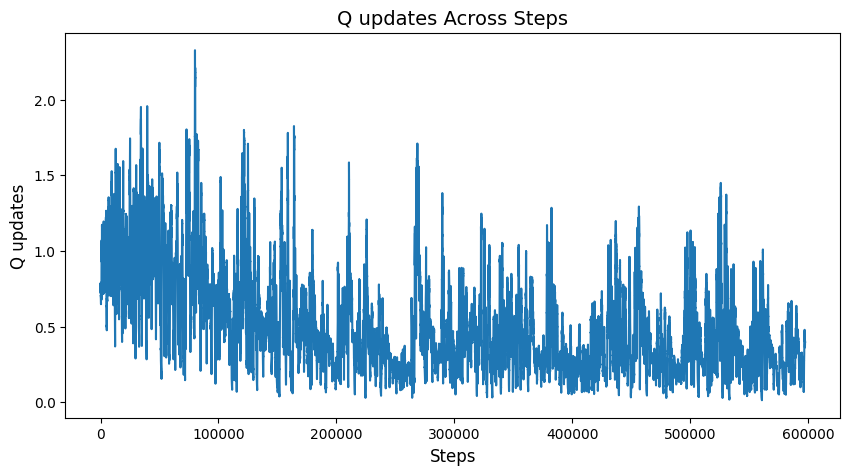

In [104]:
# Get Q updates moving average
window_size = 500
q_update_moving_avg = pd.Series(agent.q_updates).rolling(window=window_size).mean().dropna().to_list()

# Plot the q_updates across steps
plt.figure(figsize=(10, 5))
plt.plot(q_update_moving_avg)

plt.xlabel('Steps', fontsize=12)
plt.ylabel('Q updates', fontsize=12)
plt.title('Q updates Across Steps', fontsize=14)
plt.show()

#### Small bins


In [5]:
agent = DynaAgent(discr_step=(0.015, 0.0025))
rewards = []
durations = []

for episode in tqdm(range(3000)):
    state, _ = agent.env.reset()
    done = False
    truncated = False
    total_reward = []
    steps = 0
    while not done and not truncated:
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = agent.env.step(action)
        agent.observe(state, action, next_state, reward)
        state = next_state
        total_reward.append(reward)
        steps += 1

    agent.decay_epsilon()
    durations.append(steps)
    rewards.append(total_reward)

# # Save the model
# save_model(agent, "new/4_small_bins_stats.pkl", rewards, durations)

100%|██████████| 3000/3000 [50:39<00:00,  1.01s/it] 


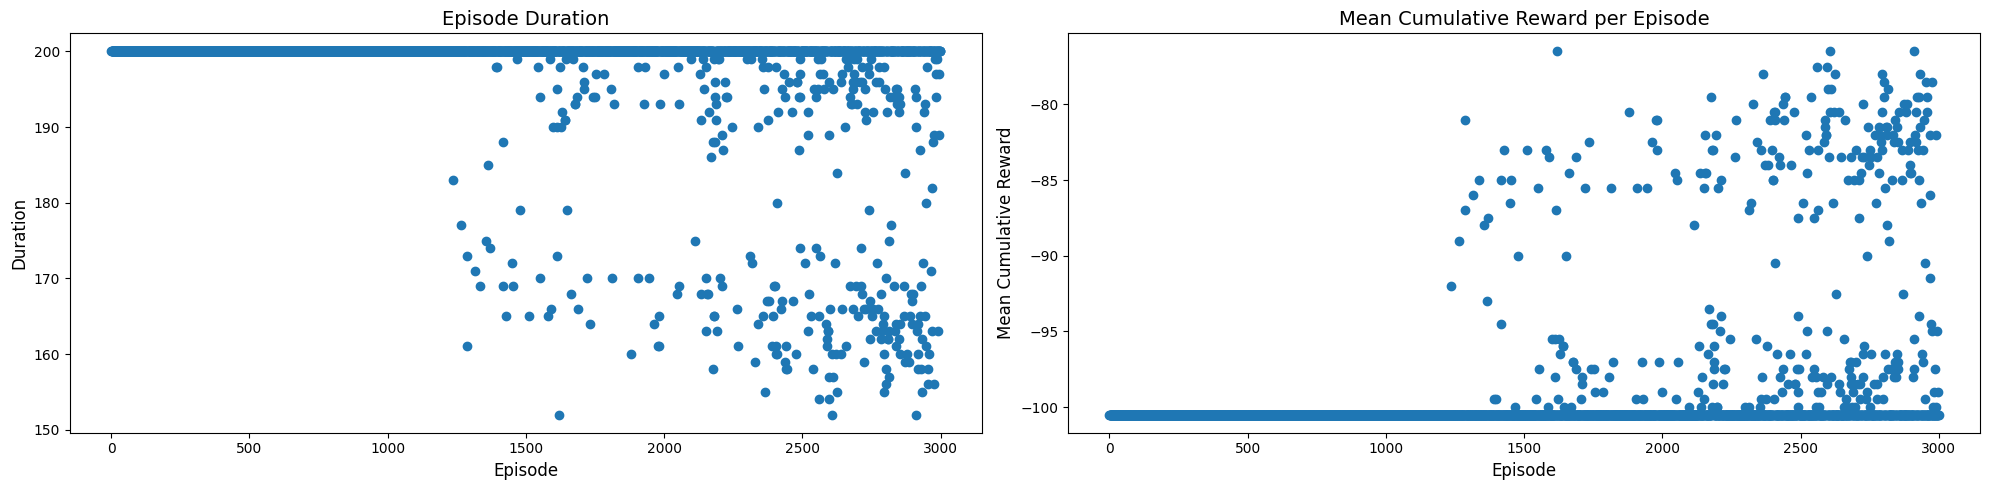

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].scatter(range(len(durations)), durations)
axs[0].set_title('Episode Duration', fontsize=14)
axs[0].set_xlabel('Episode', fontsize=12)
axs[0].set_ylabel('Duration', fontsize=12)

cum_reward = [np.mean(np.cumsum(reward)) for reward in rewards]
axs[1].scatter(range(len(cum_reward)), cum_reward)
axs[1].set_title('Mean Cumulative Reward per Episode', fontsize=14)
axs[1].set_xlabel('Episode', fontsize=12)
axs[1].set_ylabel('Mean Cumulative Reward', fontsize=12)
plt.tight_layout()
plt.show()

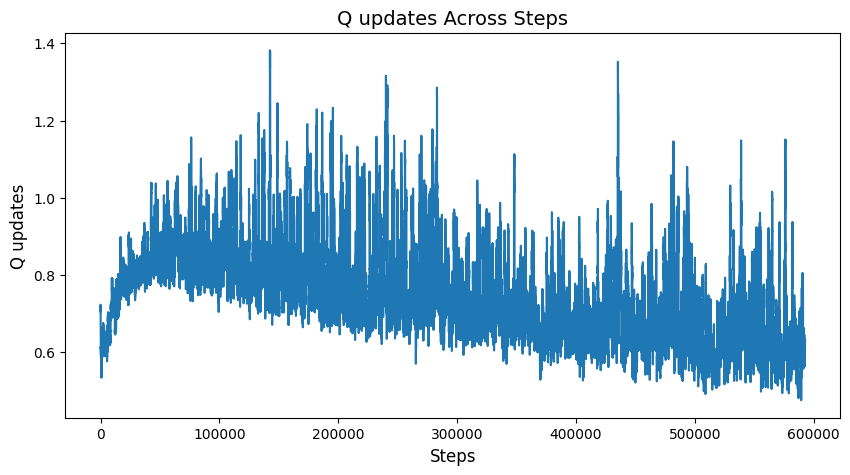

In [7]:
# Get Q updates moving average
window_size = 500
q_update_moving_avg = pd.Series(agent.q_updates).rolling(window=window_size).mean().dropna().to_list()

# Plot the q_updates across steps
plt.figure(figsize=(10, 5))
plt.plot(q_update_moving_avg)

plt.xlabel('Steps', fontsize=12)
plt.ylabel('Q updates', fontsize=12)
plt.title('Q updates Across Steps', fontsize=14)
plt.show()

# Testing


### Heuristic Reward


In [ ]:
# Initialization
agent = DQNAgent(n_episodes=1000)
episode_length = []
episode_termination = []

# Load the policy network
model_path = 'new/3_3_dqn_policy_net_abs_2pos_vel.pt'
agent.policy_net.load_state_dict(torch.load(model_path))

for episode in tqdm(range(agent.n_episodes)):
    state = agent.reset()

    for step in itertools.count():
        # Select Action
        action = agent.select_action(state=state, explore=False)

        # Observe
        next_state, _, _ = agent.observe(action=action)

        # Update the state
        state = copy(next_state)

        if agent.done:
            episode_length.append(step)
            episode_termination.append(int(agent.terminated))

            if (episode) % 100 == 0:
                print()
                print(f"Cum success: {sum(episode_termination)}")
            break

  0%|          | 4/1000 [00:00<00:57, 17.26it/s]


Cum success: 1


 10%|█         | 104/1000 [00:05<00:42, 20.94it/s]


Cum success: 101


 20%|██        | 203/1000 [00:11<00:38, 20.60it/s]


Cum success: 201


 30%|███       | 305/1000 [00:16<00:31, 22.00it/s]


Cum success: 301


 40%|████      | 403/1000 [00:20<00:34, 17.29it/s]


Cum success: 401


 50%|█████     | 502/1000 [00:26<00:21, 22.67it/s]


Cum success: 501


 60%|██████    | 605/1000 [00:31<00:18, 21.28it/s]


Cum success: 601


 70%|███████   | 703/1000 [00:36<00:18, 15.98it/s]


Cum success: 701


 80%|████████  | 805/1000 [00:43<00:09, 21.03it/s]


Cum success: 801


 90%|█████████ | 905/1000 [00:47<00:04, 20.90it/s]


Cum success: 901


100%|██████████| 1000/1000 [00:53<00:00, 18.86it/s]


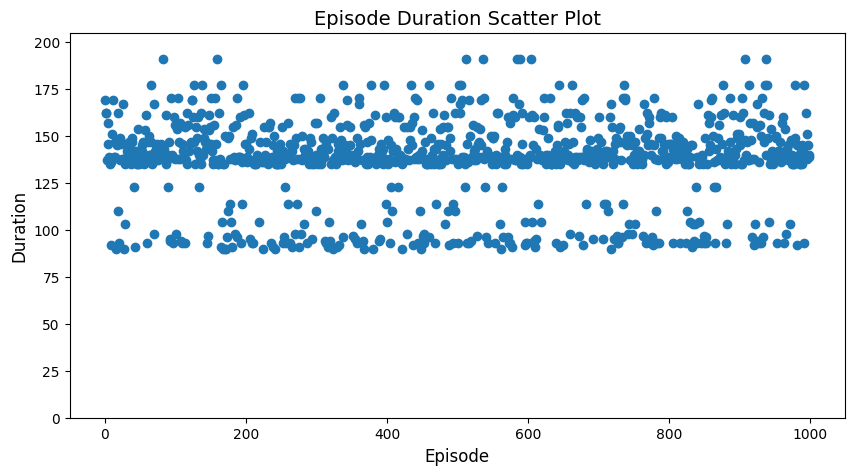

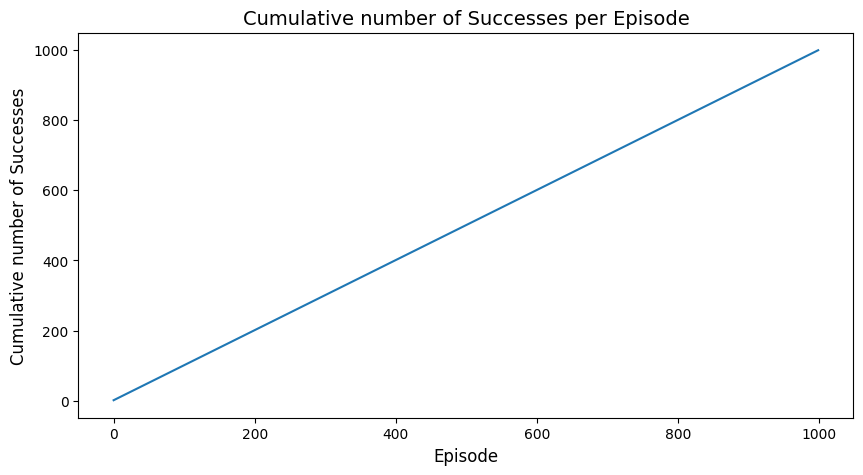

In [ ]:
# Plot duration of each episode
plt.figure(figsize=(10, 5))
plt.scatter(range(len(episode_length)), episode_length, marker='o')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Duration', fontsize=12)
plt.title('Episode Duration Scatter Plot', fontsize=14)
plt.ylim(0, 205)
plt.show()

# Plot the cumulative number of successes
cum_termination = np.cumsum(episode_termination)
plt.figure(figsize=(10, 5))
plt.plot(cum_termination)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Cumulative number of Successes', fontsize=12)
plt.title('Cumulative number of Successes per Episode', fontsize=14)
plt.show()

### RND


In [ ]:
# Initialization
agent = DQNAgent(n_episodes=1000)
episode_length = []
episode_termination = []

# Load the policy network
model_path = 'new/3_4_dqn_policy_net.pt'
agent.policy_net.load_state_dict(torch.load(model_path))

for episode in tqdm(range(agent.n_episodes)):
    state = agent.reset()

    for step in itertools.count():
        # Select Action
        action = agent.select_action(state=state, explore=False)

        # Observe
        next_state, _, _ = agent.observe(action=action)

        # Update the state
        state = copy(next_state)

        if agent.done:
            episode_length.append(step)
            episode_termination.append(int(agent.terminated))

            if (episode) % 100 == 0:
                print()
                print(f"Cum success: {sum(episode_termination)}")
            break

  1%|          | 6/1000 [00:00<00:40, 24.39it/s]


Cum success: 1


 10%|█         | 105/1000 [00:04<00:36, 24.29it/s]


Cum success: 101


 20%|██        | 203/1000 [00:08<00:47, 16.95it/s]


Cum success: 201


 30%|███       | 303/1000 [00:13<00:28, 24.59it/s]


Cum success: 301


 40%|████      | 404/1000 [00:17<00:23, 24.85it/s]


Cum success: 401


 50%|█████     | 502/1000 [00:25<01:21,  6.10it/s]


Cum success: 501


 60%|██████    | 601/1000 [00:37<01:40,  3.96it/s]


Cum success: 601


 70%|███████   | 703/1000 [00:50<00:20, 14.25it/s]


Cum success: 701


 80%|████████  | 803/1000 [01:00<00:13, 14.38it/s]


Cum success: 801


 90%|█████████ | 905/1000 [01:05<00:03, 23.89it/s]


Cum success: 901


100%|██████████| 1000/1000 [01:09<00:00, 14.39it/s]


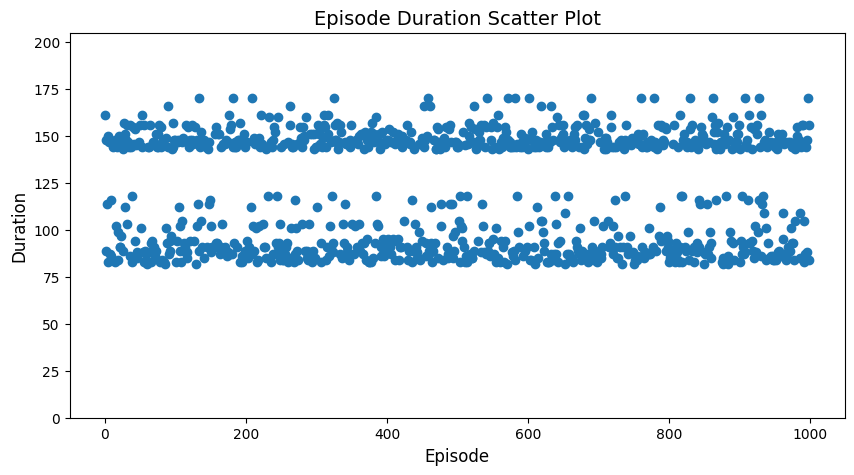

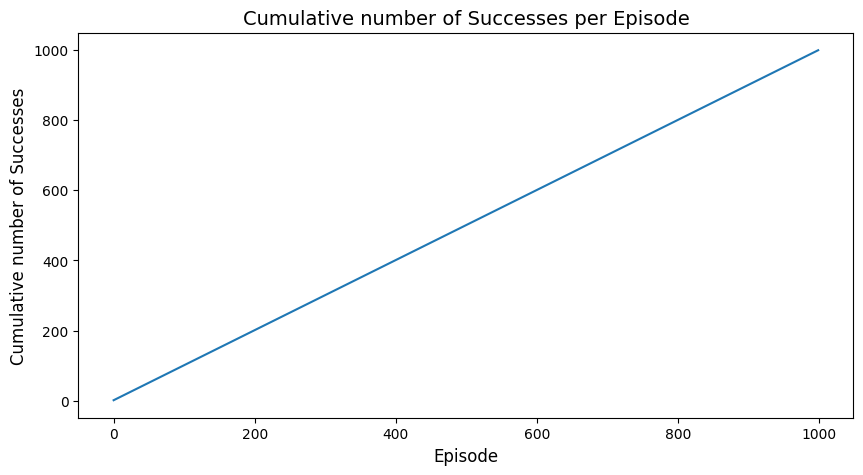

In [ ]:
# Plot duration of each episode
plt.figure(figsize=(10, 5))
plt.scatter(range(len(episode_length)), episode_length, marker='o')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Duration', fontsize=12)
plt.title('Episode Duration Scatter Plot', fontsize=14)
plt.ylim(0, 205)
plt.show()

# Plot the cumulative number of successes
cum_termination = np.cumsum(episode_termination)
plt.figure(figsize=(10, 5))
plt.plot(cum_termination)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Cumulative number of Successes', fontsize=12)
plt.title('Cumulative number of Successes per Episode', fontsize=14)
plt.show()

### Dyna


In [12]:
# Load the Dyna model
agent = DynaAgent()
load_model(agent, "4_normal_bins_stats.pkl")
agent.epsilon = 0

# Initialization
episode_length = []
episode_termination = []

# Testing Loop
for episode in tqdm(range(1000)):
    state, _ = agent.env.reset()
    done = False
    truncated = False
    steps = 0
    while not done and not truncated:
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = agent.env.step(action)
        state = next_state
        steps += 1
    episode_length.append(steps)
    episode_termination.append(int(done))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 138.12it/s]


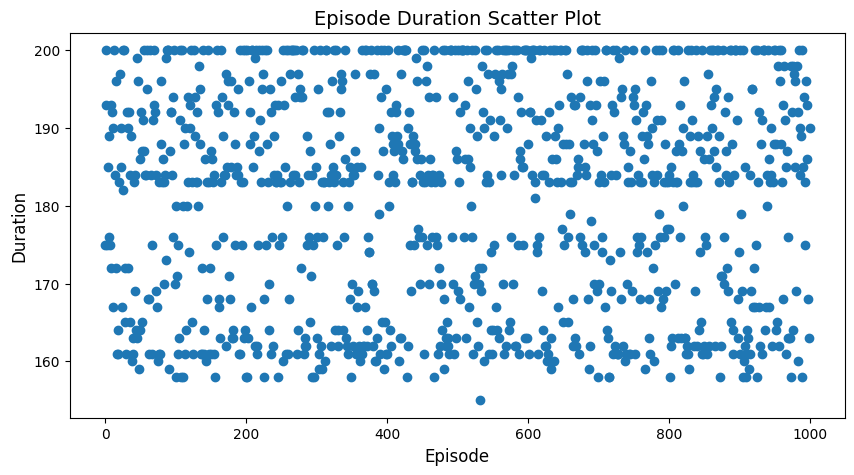

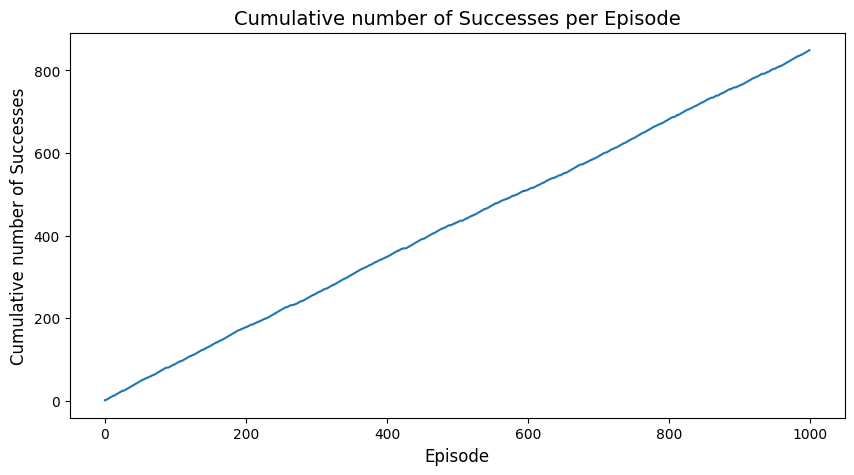

In [13]:
# Plot duration of each episode
plt.figure(figsize=(10, 5))
plt.scatter(range(len(episode_length)), episode_length, marker='o')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Duration', fontsize=12)
plt.title('Episode Duration Scatter Plot', fontsize=14)
plt.show()

# Plot the cumulative number of successes
cum_termination = np.cumsum(episode_termination)
plt.figure(figsize=(10, 5))
plt.plot(cum_termination)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Cumulative number of Successes', fontsize=12)
plt.title('Cumulative number of Successes per Episode', fontsize=14)
plt.show()